In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [52]:
#parameters
num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [12]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5,0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0
    x = x.reshape((batch_size, -1))
    y = x.reshape((batch_size, -1))
    return (x,y)


In [16]:
#placeholders 
batch_x_pla = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batch_y_pla = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [17]:
#weights and biases as tf variables
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [34]:
#unpacking to ressemble actual RNN
inputs_series = tf.unstack(batch_x_pla, axis=1)
labels_series = tf.unstack(batch_y_pla, axis=1)
inputs_series


[<tf.Tensor 'unstack_18:0' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:1' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:2' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:3' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:4' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:5' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:6' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:7' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:8' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:9' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:10' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:11' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:12' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:13' shape=(5,) dtype=float32>,
 <tf.Tensor 'unstack_18:14' shape=(5,) dtype=float32>]

In [36]:
#computation
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

In [47]:
#calculating loss
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=log, labels=lab) for log, lab in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [48]:
#plotting
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.660515
Step 100 Loss 0.00720117
Step 200 Loss 0.00315828
Step 300 Loss 0.00193661
Step 400 Loss 0.00143539
Step 500 Loss 0.00109406
Step 600 Loss 0.000871311
New data, epoch 1
Step 0 Loss 0.000792551
Step 100 Loss 0.000682478
Step 200 Loss 0.000574304
Step 300 Loss 0.00051131
Step 400 Loss 0.000453817
Step 500 Loss 0.000402836
Step 600 Loss 0.000371535
New data, epoch 2
Step 0 Loss 0.000418491
Step 100 Loss 0.000326497
Step 200 Loss 0.000319878
Step 300 Loss 0.00028802
Step 400 Loss 0.00026933
Step 500 Loss 0.00025643
Step 600 Loss 0.00023569
New data, epoch 3
Step 0 Loss 0.000266859
Step 100 Loss 0.00022855
Step 200 Loss 0.000212208
Step 300 Loss 0.000200954
Step 400 Loss 0.000185237
Step 500 Loss 0.000180242
Step 600 Loss 0.000166691
New data, epoch 4
Step 0 Loss 0.000183706
Step 100 Loss 0.00015967
Step 200 Loss 0.00014887
Step 300 Loss 0.000146466
Step 400 Loss 0.000144921
Step 500 Loss 0.000136258
Step 600 Loss 0.000135967
New data, epoch 5
Step 0 L

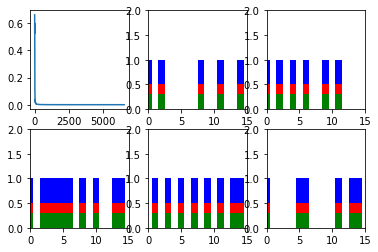

In [53]:
#training
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batch_x_pla:batchX,
                    batch_y_pla:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)
                
#prediction
plt.ioff()
plt.show()